In [78]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split


In [106]:
data = pd.read_csv("data_before.csv")

In [107]:
metric_features = ['Age','Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses','Freq_Visits_Day', 'Visits_ActivePeriod', 'Active_Period','MonthlyValue']

non_metric_features = data.columns.drop(metric_features).to_list()

In [108]:
activities = ['AthleticsActivities', 'WaterActivities','FitnessActivities','TeamActivities','RacketActivities','CombatActivities','SpecialActivities','OtherActivities']


In [109]:
attendance_perspective = metric_features
compare = ['UseByTime','Dropout', 'Gender_Female']
df_activities = data[activities].copy()
df_attendance = data[attendance_perspective].copy()
df_compare = data[compare].copy()

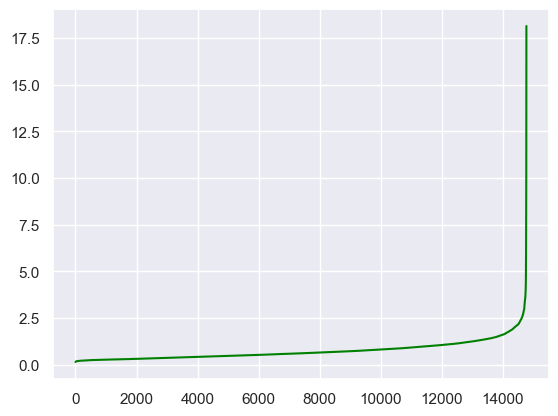

In [110]:
# Detection of the reamining outliers trough DBSCAN
# epsilon of 2.2
neigh = NearestNeighbors(n_neighbors = (2 * len(metric_features)) - 1)
neigh.fit(data[metric_features])
distances, _ = neigh.kneighbors(data[metric_features])
distances = np.sort(distances[:, -1])
#plt.yticks(np.arange(1,22,0.5))
plt.plot(distances, color = 'green')
plt.show()

In [111]:
dbscan = DBSCAN(eps=2.25, min_samples = 2 * len(metric_features), n_jobs = -1)
dbscan_labels = dbscan.fit_predict(data[metric_features])

Counter(dbscan_labels)

Counter({0: 14687, -1: 86})

In [112]:
data = pd.concat([data, pd.Series(dbscan_labels, name = 'dbscan_labels', index = data.index)], axis =1)

In [113]:
data_dbscan_out = data[dbscan_labels == -1]
data = data[dbscan_labels != -1]

In [114]:
data.set_index('ID')

,Age,Income,DaysWithoutFrequency,LifetimeValue,UseByTime,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,...,Contract_Duration,PercentageOfVisits,TotalNumberOfActivities,MonthlyValue,PercentageOfClasses,Freq_Visits_Day,Freq_Classes_Contract,Visits_ActivePeriod,Gender_Female,dbscan_labels
ID,,,,,,,,,,,,,,,,,,,,,
10000,3.083333,2.674242,-0.600000,-0.278298,0,0.0,0.0,1.0,0.0,0.0,...,-0.490868,1.15,0.0,3.017065,1.866571,0.763419,9.579365,-0.201465,1,0
10001,0.500000,0.500000,0.307692,1.182909,0,0.0,0.0,0.0,0.0,0.0,...,0.285388,-0.20,0.0,0.607509,0.104392,-0.204771,0.198413,-0.501832,1,0
10002,0.000000,0.007576,-0.507692,-0.472264,0,0.0,0.0,1.0,0.0,0.0,...,-0.554795,0.50,0.0,0.493905,0.000000,1.208748,0.000000,0.619048,0,0
10003,-1.166667,-1.492424,-0.276923,-0.030735,0,0.0,0.0,0.0,1.0,0.0,...,-0.257991,0.35,0.0,0.176012,0.239981,0.463221,0.992063,-0.300366,0,0
10004,1.000000,1.780303,2.615385,0.785607,0,0.0,0.0,1.0,0.0,0.0,...,1.152968,-0.50,0.0,-0.611409,0.000000,-0.255467,0.000000,-0.600733,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24937,-0.750000,-1.492424,-0.584615,4.860757,0,0.0,1.0,0.0,0.0,0.0,...,1.997717,0.65,0.0,0.585080,2.056875,0.190855,6.634921,1.000000,0,0
24938,1.333333,1.045455,-0.030769,0.675600,0,0.0,0.0,0.0,0.0,0.0,...,-0.027397,-0.25,0.0,0.756216,0.000000,1.391650,0.000000,0.007326,0,0
24939,-0.250000,-0.121212,-0.584615,-0.449775,0,0.0,0.0,1.0,0.0,0.0,...,-0.554795,0.85,0.0,0.786446,0.000000,1.208748,0.000000,1.025641,0,0


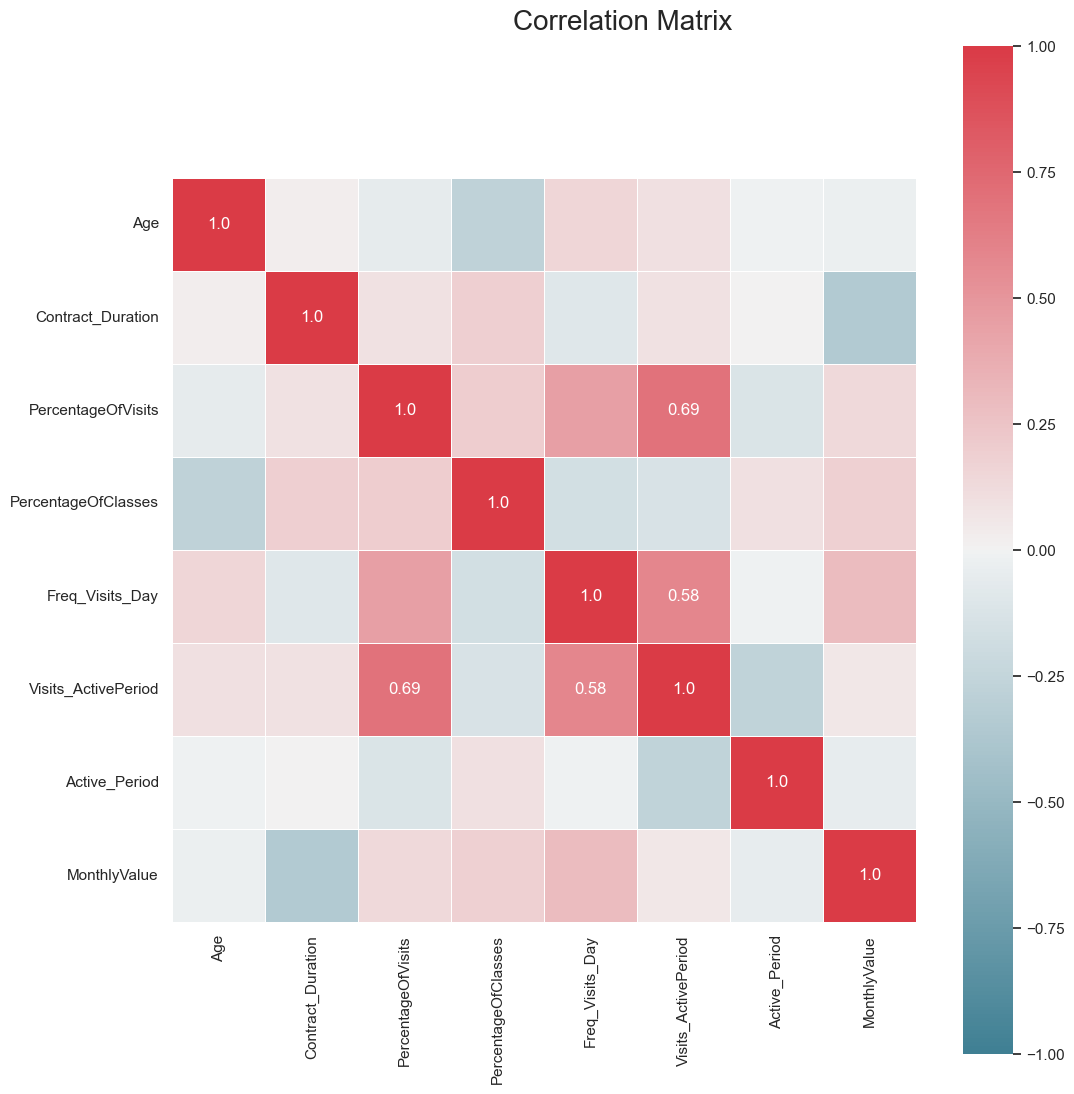

In [115]:
# Prepare figure
fig = plt.figure(figsize=(12, 12))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(data[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values)>= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

#plt.savefig(os.path.join('..', 'figures', 'exp_analysis', 'correlation_matrix.png'), dpi=200)

plt.show()

In [116]:
delete = ['ID', 'Income', 'DaysWithoutFrequency', 'LifetimeValue',
       'UseByTime', 'NumberOfFrequencies', 'AttendedClasses', 'AllowedWeeklyVisitsBySLA',
       'AllowedNumberOfVisitsBySLA', 'RealNumberOfVisits', 'NumberOfRenewals',
       'HasReferences', 'NumberOfReferences', 'TotalNumberOfActivities',
       'dbscan_labels', 'Freq_Classes_Contract']
data.drop(columns = delete, inplace = True)

In [117]:
data.columns

Index(['Age', 'AthleticsActivities', 'WaterActivities', 'FitnessActivities',
       'TeamActivities', 'RacketActivities', 'CombatActivities',
       'SpecialActivities', 'OtherActivities', 'Dropout', 'Active_Period',
       'Contract_Duration', 'PercentageOfVisits', 'MonthlyValue',
       'PercentageOfClasses', 'Freq_Visits_Day', 'Visits_ActivePeriod',
       'Gender_Female'],
      dtype='object')

In [118]:
metric_features

['Age',
 'Contract_Duration',
 'PercentageOfVisits',
 'PercentageOfClasses',
 'Freq_Visits_Day',
 'Visits_ActivePeriod',
 'Active_Period',
 'MonthlyValue']

In [119]:
# Split variables into perspectives (example, requires critical thinking and domain knowledge)
demographic_features = [
    'Contract_Duration',
    'Age',
    'Active_Period',
    'MonthlyValue'
]

attendance_features = [
   'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Visits_ActivePeriod'
]

df_dem = data[demographic_features].copy()
df_att = data[attendance_features].copy()

In [120]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

## Finding the optimal clusterer on demographic variables

In [121]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_dem, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_dem, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.268875,0.057110,0.083328,0.000691,0.201644
3,0.435553,0.238859,0.083587,0.002181,0.368119
4,0.542454,0.427350,0.096338,0.002437,0.469989
5,0.600597,0.434889,0.309086,0.002584,0.539211
6,0.641407,0.490251,0.309959,0.003363,0.590800
7,0.675866,0.501684,0.315849,0.003376,0.630527
8,0.708958,0.507324,0.317968,0.007190,0.658775
9,0.735162,0.548836,0.356714,0.007453,0.679054


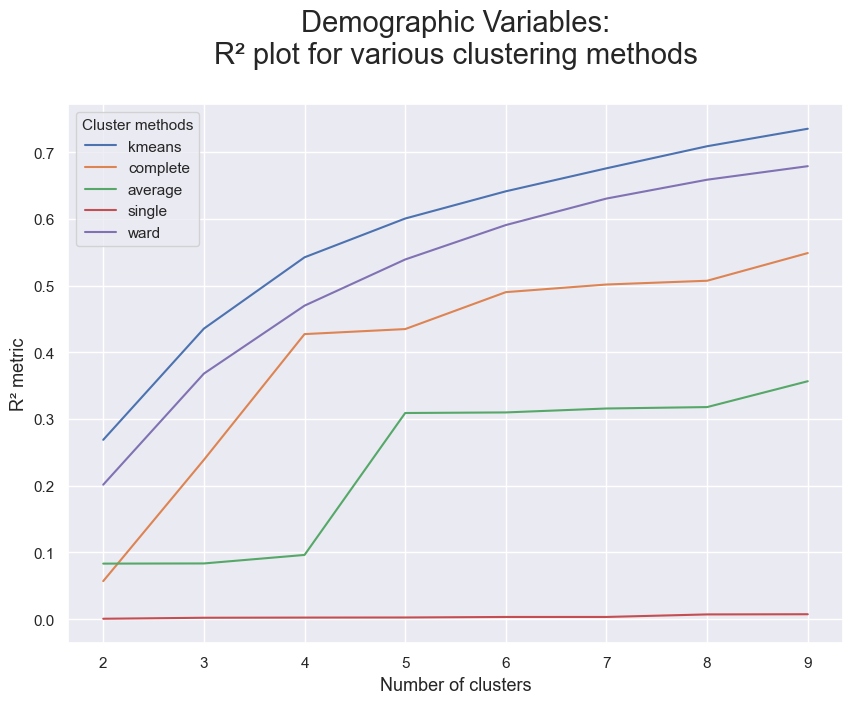

In [122]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

## Repeat the process for attendance variables

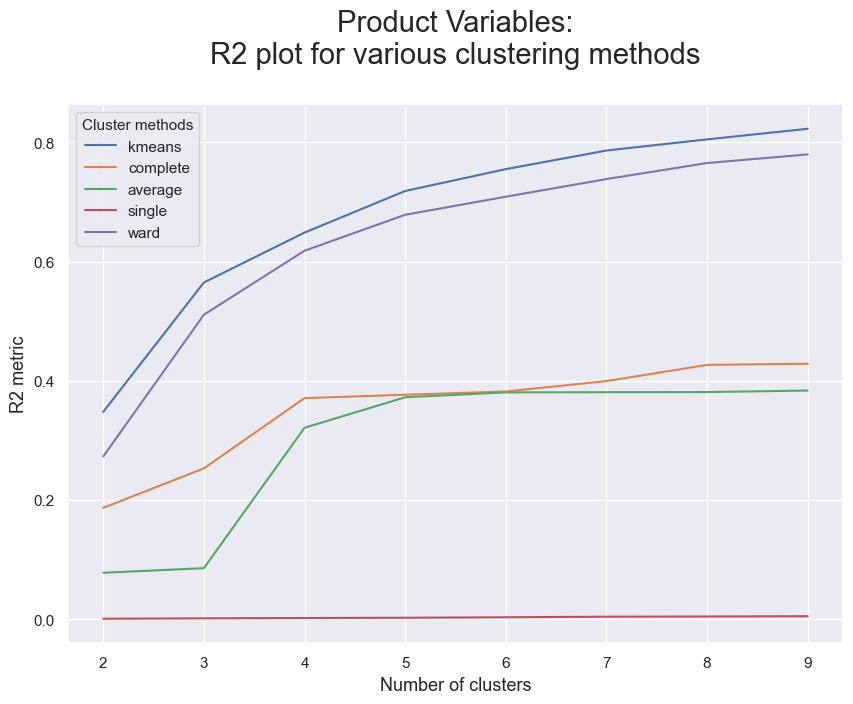

In [123]:
# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_att, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_att, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

## Merging the Perspectives

In [124]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_prod = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
attendance_labels = kmeans_prod.fit_predict(df_att)

kmeans_behav = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
behavior_labels = kmeans_behav.fit_predict(df_dem)

data['attendance_labels'] = attendance_labels
data['behavior_labels'] = behavior_labels

In [125]:
pd.crosstab(data['behavior_labels'],
            data['attendance_labels'])

attendance_labels,0,1,2,3
behavior_labels,,,,
0,1744,1017,3980,334
1,569,449,1049,253
2,715,1076,1089,277
3,368,813,790,164


## Manual merging: Merge lowest frequency clusters into closest clusters

In [126]:
# Centroids of clusters
df_centroids = data.groupby(['behavior_labels', 'attendance_labels'])\
    [metric_features].mean()


# Clusters with low frequency to be merged:
# (behavior_labels, product_labels)
to_merge = [(3,2), (1,3), (2,2), (2,3)]


# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(
    euclidean, columns=df_centroids.index, index=df_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(3, 2): (3, 0), (1, 3): (0, 3), (2, 2): (0, 2), (2, 3): (0, 3)}

In [127]:
df_ = data.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['behavior_labels']==source[0]) & (df_['attendance_labels']==source[1])
    df_.loc[mask, 'behavior_labels'] = target[0]
    df_.loc[mask, 'attendance_labels'] = target[1]

# New contigency table

pd.crosstab(df_['behavior_labels'],
            df_['attendance_labels'])

attendance_labels,0,1,2,3
behavior_labels,,,,
0,1744,1017,5069,864
1,569,449,1049,0
2,715,1076,0,0
3,1158,813,0,164


## Merging using Hierarchical clustering

In [128]:
# Centroids of the concatenated cluster labels
df_centroids = data.groupby(['behavior_labels', 'attendance_labels'])\
    [metric_features].mean()
df_centroids

Age  Contract_Duration  \
behavior_labels attendance_labels                                
0               0                  0.078842           0.007090   
                1                 -0.279826           0.201171   
                2                  0.046231          -0.004343   
                3                  0.170409           0.063729   
1               0                  2.399238           0.317781   
                1                  2.201373           0.372944   
                2                  2.292660           0.236875   
                3                  2.541173           0.567311   
2               0                 -0.025641          -0.449047   
                1                 -1.180065           0.023540   
                2                 -0.171411          -0.408273   
                3                 -0.168171          -0.328503   
3               0                  0.362545           2.122301   
                1                 -0.811193           2.127093   
                2                  0.216034           2.015872   
                3                  0.375000           2.326679   

                                   PercentageOfVisits  PercentageOfClasses  \
behavior_labels attendance_labels                                            
0               0                            0.571445             0.019899   
                1                            0.294887             2.204340   
                2                           -0.218229             0.020111   
                3                            1.888922             0.154760   
1               0                            0.484798             0.066284   
                1                            0.390312             2.132952   
                2                           -0.306768             0.041635   
                3                            1.866798             0.358381   
2               0                            0.523566             0.067973   
                1                            0.596794             2.185855   
                2                           -0.208724             0.072579   
                3                            1.961733             0.523350   
3               0                            0.645516             0.066513   
                1                            0.598647             2.147748   
                2                           -0.180190             0.069371   
                3                            2.027744             0.453795   

                                   Freq_Visits_Day  Visits_ActivePeriod  \
behavior_labels attendance_labels                                         
0               0                         0.804613             0.819097   
                1                        -0.166185            -0.268094   
                2                        -0.167809            -0.225696   
                3                         1.933257             2.777248   
1               0                         1.045043             0.813946   
                1                        -0.012566            -0.162143   
                2                        -0.109286            -0.318165   
                3                         1.984752             3.208140   
2               0                         1.133279             0.669192   
                1                        -0.010190            -0.007823   
                2                        -0.128431            -0.231180   
                3                         2.669794             2.576639   
3               0                         0.557495             1.026258   
                1                        -0.111432             0.036734   
                2                        -0.302904            -0.162350   
                3                         1.367642             3.521286   

                                   Active_Period  MonthlyValue  
behavior_labels attendance_lab

In [129]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

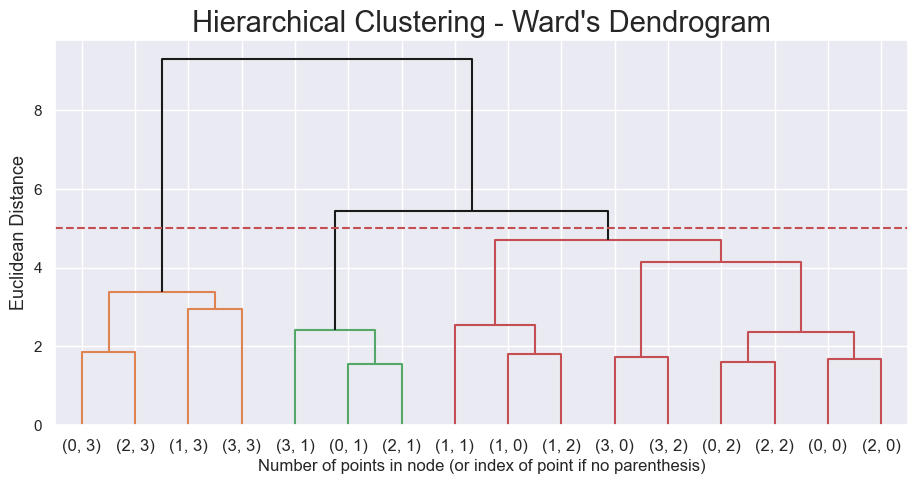

In [130]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 5
dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [131]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

Age  Contract_Duration  \
behavior_labels attendance_labels                                
0               0                  0.078842           0.007090   
                1                 -0.279826           0.201171   
                2                  0.046231          -0.004343   
                3                  0.170409           0.063729   
1               0                  2.399238           0.317781   
                1                  2.201373           0.372944   
                2                  2.292660           0.236875   
                3                  2.541173           0.567311   
2               0                 -0.025641          -0.449047   
                1                 -1.180065           0.023540   
                2                 -0.171411          -0.408273   
                3                 -0.168171          -0.328503   
3               0                  0.362545           2.122301   
                1                 -0.811193           2.127093   
                2                  0.216034           2.015872   
                3                  0.375000           2.326679   

                                   PercentageOfVisits  PercentageOfClasses  \
behavior_labels attendance_labels                                            
0               0                            0.571445             0.019899   
                1                            0.294887             2.204340   
                2                           -0.218229             0.020111   
                3                            1.888922             0.154760   
1               0                            0.484798             0.066284   
                1                            0.390312             2.132952   
                2                           -0.306768             0.041635   
                3                            1.866798             0.358381   
2               0                            0.523566             0.067973   
                1                            0.596794             2.185855   
                2                           -0.208724             0.072579   
                3                            1.961733             0.523350   
3               0                            0.645516             0.066513   
                1                            0.598647             2.147748   
                2                           -0.180190             0.069371   
                3                            2.027744             0.453795   

                                   Freq_Visits_Day  Visits_ActivePeriod  \
behavior_labels attendance_labels                                         
0               0                         0.804613             0.819097   
                1                        -0.166185            -0.268094   
                2                        -0.167809            -0.225696   
                3                         1.933257             2.777248   
1               0                         1.045043             0.813946   
                1                        -0.012566            -0.162143   
                2                        -0.109286            -0.318165   
                3                         1.984752             3.208140   
2               0                         1.133279             0.669192   
                1                        -0.010190            -0.007823   
                2                        -0.128431            -0.231180   
                3                         2.669794             2.576639   
3               0                         0.557495             1.026258   
                1                        -0.111432             0.036734   
                2                        -0.302904            -0.162350   
                3                         1.367642             3.521286   

                                   Active_Period  MonthlyValue  hclust_labels  
behavior_labels

In [132]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = data.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['behavior_labels'], row['attendance_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,Active_Period,MonthlyValue
merged_labels,,,,,,,,
0,0.048421,0.184544,0.042632,0.037033,0.157917,0.115860,0.365007,-0.064414
1,0.695282,0.442991,1.925243,0.351897,2.054159,2.947938,0.156041,0.427603
2,-0.761815,0.674207,0.491655,2.181663,-0.093107,-0.086444,0.473178,0.345997
3,2.302169,0.288704,0.062554,0.502702,0.229485,0.027372,0.412673,0.240168


In [133]:
df_

,Age,AthleticsActivities,WaterActivities,FitnessActivities,TeamActivities,RacketActivities,CombatActivities,SpecialActivities,OtherActivities,Dropout,...,Contract_Duration,PercentageOfVisits,MonthlyValue,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,Gender_Female,attendance_labels,behavior_labels,merged_labels
0,3.083333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,...,-0.490868,1.15,3.017065,1.866571,0.763419,-0.201465,1,1,1,3
1,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,...,0.285388,-0.20,0.607509,0.104392,-0.204771,-0.501832,1,2,0,0
2,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,...,-0.554795,0.50,0.493905,0.000000,1.208748,0.619048,0,0,2,0
3,-1.166667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,...,-0.257991,0.35,0.176012,0.239981,0.463221,-0.300366,0,2,2,0
4,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,...,1.152968,-0.50,-0.611409,0.000000,-0.255467,-0.600733,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14768,-0.750000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,1.997717,0.65,0.585080,2.056875,0.190855,1.000000,0,1,3,2
14769,1.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,...,-0.027397,-0.25,0.756216,0.000000,1.391650,0.007326,0,0,1,3
14770,-0.250000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,...,-0.554795,0.85,0.786446,0.000000,1.208748,1.025641,0,0,2,0
14771,2.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0.767123,1.70,0.684544,2.010559,2.240557,0.802198,0,0,1,3


In [134]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['attendace_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts.pivot(values=0, index='behavior_labels', columns='attendace_labels')

attendace_labels,1,2,3
behavior_labels,,,
1,NaN,2067.0,NaN
3,2906.0,8686.0,1028.0


In [135]:
# Setting df to have the final product, behavior and merged clusters
df = df_.copy()

## Cluster Analysis


In [136]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

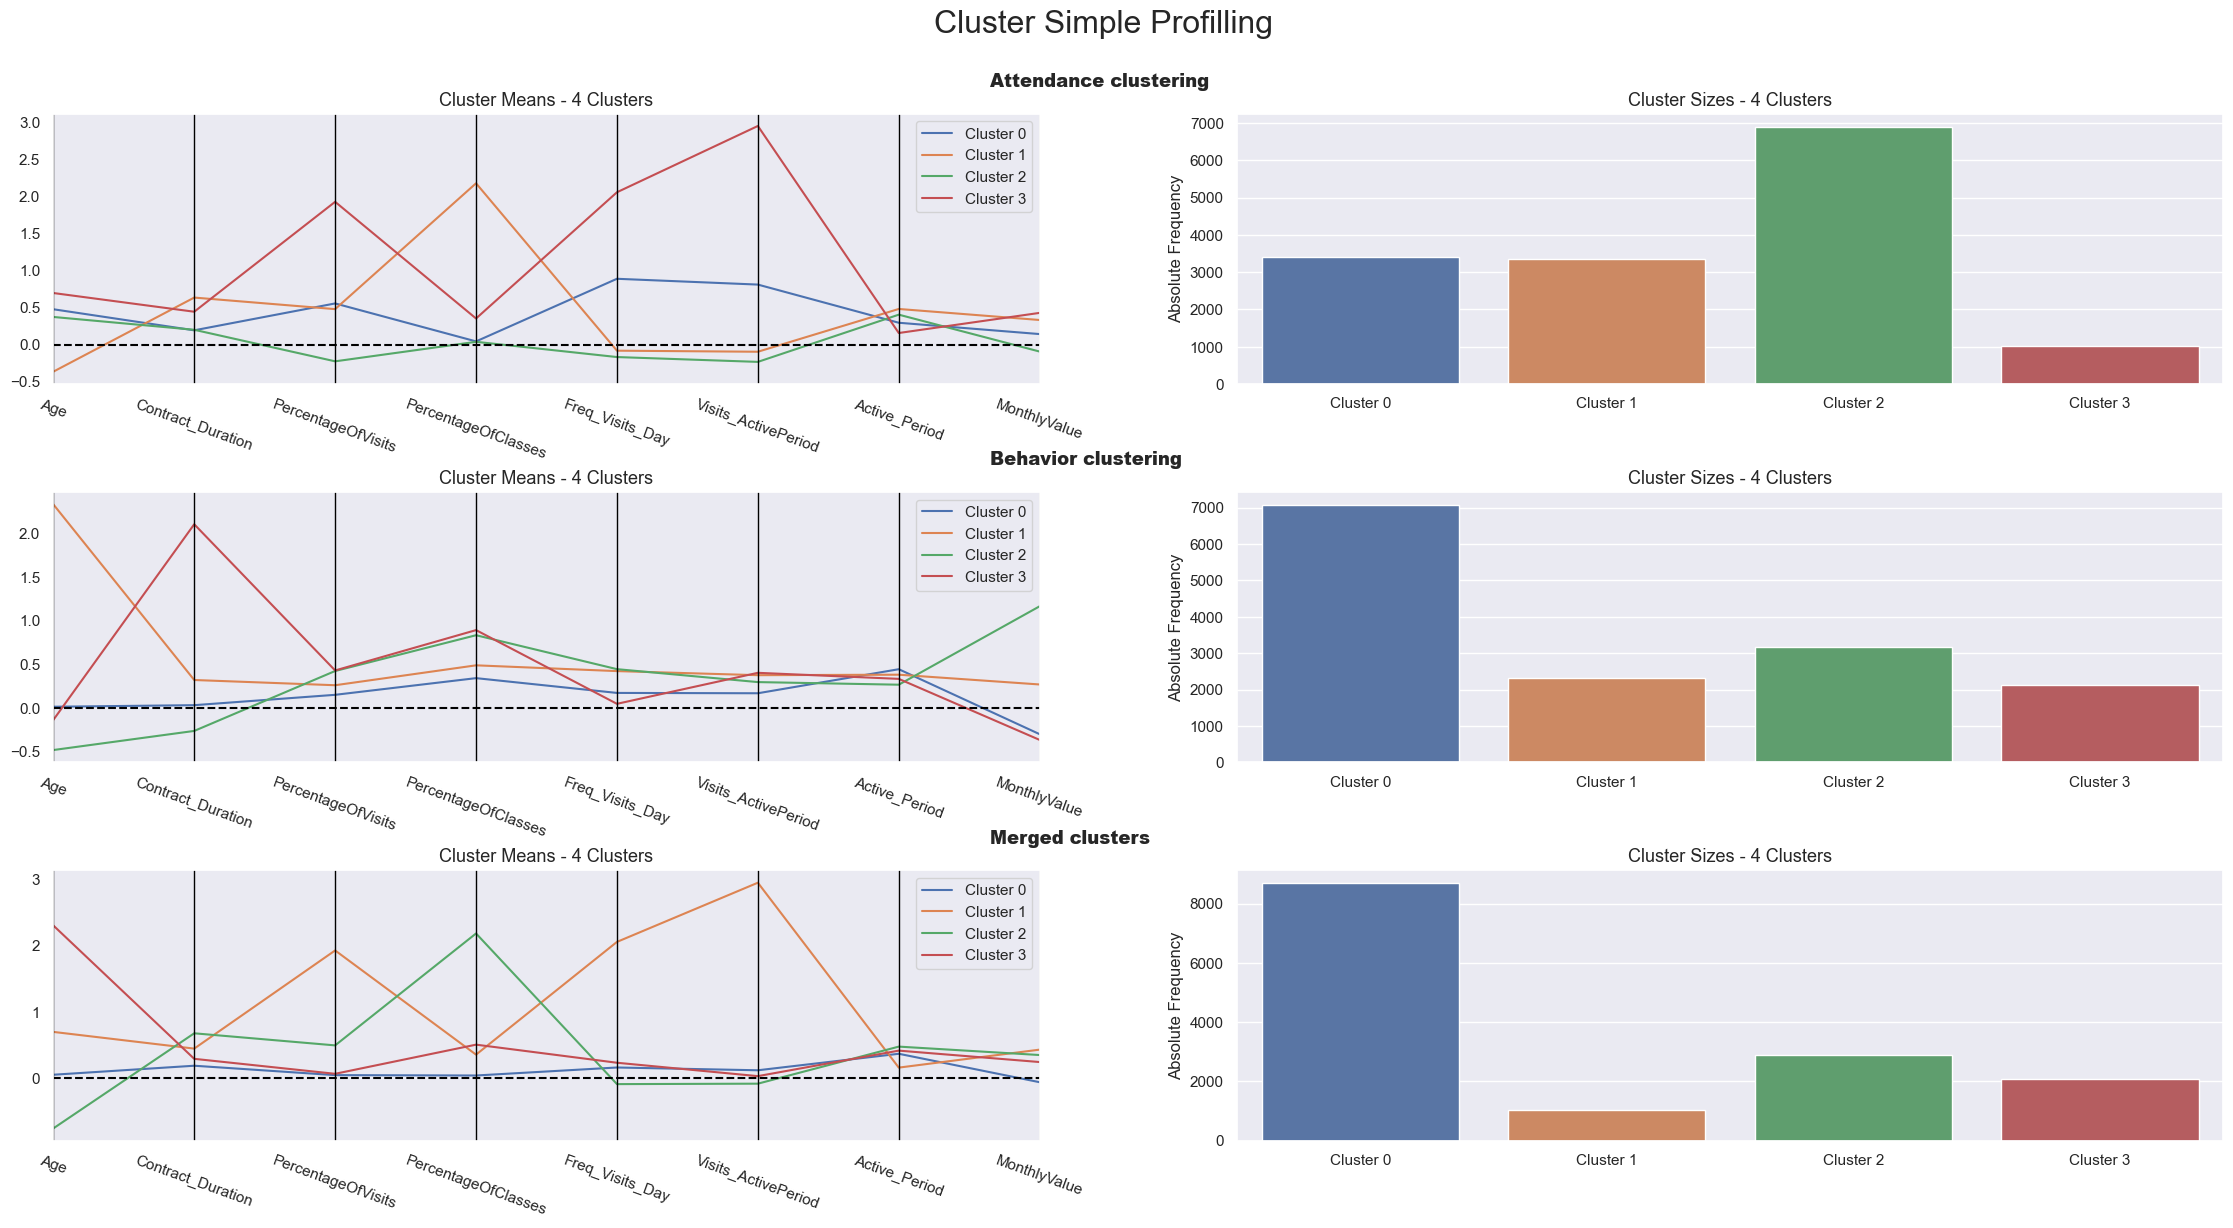

In [137]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['attendance_labels', 'behavior_labels', 'merged_labels']], 
    label_columns = ['attendance_labels', 'behavior_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Attendance clustering", "Behavior clustering", "Merged clusters"]
)